In [1]:
!git clone https://github.com/ranbeer06052009/MulG-Research.git

Cloning into 'MulG-Research'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 140 (delta 10), reused 16 (delta 6), pack-reused 118 (from 1)
Receiving objects: 100% (140/140), 329.17 MiB | 35.73 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Updating files: 100% (98/98), done.


In [2]:
import gdown

file_id = "1_XdzdW8UNG1TTS6QcX10uhoS6N11OBit"
destination = "mosi_data.pkl"

gdown.download(
    f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1_XdzdW8UNG1TTS6QcX10uhoS6N11OBit
From (redirected): https://drive.google.com/uc?id=1_XdzdW8UNG1TTS6QcX10uhoS6N11OBit&confirm=t&uuid=8b7408f0-fc56-48e2-801d-b4d7d79f3474
To: /content/mosi_data.pkl
100%|██████████| 154M/154M [00:00<00:00, 178MB/s]


'mosi_data.pkl'

In [3]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('/content/MulG-Research/src')

In [22]:
from loader import get_dataloader
from unimodals.modules import Transformer, MLP, Sequential, Identity
from training.supervised1 import train, test, MMDL
from fusions.MulG import MulGFusion
from utils import get_default_device, save_results

In [11]:
FILE_PATH = '/content/mosi_data.pkl'
train_data, valid_data, test_data = get_dataloader(
    filepath=FILE_PATH,
    batch_size=32,
    max_seq_len=30,
    task="classification",   # ⭐ THIS FIXES LABELS
)


In [12]:
device = get_default_device()
print(device)

cuda


In [13]:
from unimodals.mulg_module import TextEncoder, AudioEncoder, VisionEncoder
import torch.nn as nn
# feature dimensions (check your dataset)
text_dim   = 300
audio_dim  = 5
vision_dim = 20

hidden_dim = 50

encoders = [
    VisionEncoder(vision_dim, hidden_dim).to(device),
    AudioEncoder(audio_dim, hidden_dim).to(device),
    TextEncoder(text_dim, hidden_dim).to(device),
]

fusion = MulGFusion(
    d_l=hidden_dim,
    d_a=hidden_dim,
    d_v=hidden_dim,
    hidden_dim=hidden_dim
).to(device)

head = nn.Linear(3 * hidden_dim, 2).to(device)   # Acc2


In [15]:
j = next(iter(train_data))
modalities = j[0]

with torch.no_grad():
    outs = [enc(m.cuda()) for enc, m in zip(encoders, modalities)]

for o in outs:
    print(o.shape)


torch.Size([32, 50, 50])
torch.Size([32, 50, 50])
torch.Size([32, 50, 50])


In [16]:
j = next(iter(train_data))
print(j[-1][:10])


tensor([[0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1]])


In [17]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [18]:
OUTPUT_MODEL_FILE_NAME = "MulG_Model"

train_losses, valid_losses = train(
    encoders=encoders,
    fusion=fusion,
    head=head,
    train_dataloader=train_data,
    valid_dataloader=valid_data,
    total_epochs=100,
    optimtype=torch.optim.AdamW,
    lr=1e-4,
    weight_decay=0.01,
    early_stop=True,
    save=f"/content/{OUTPUT_MODEL_FILE_NAME}.pt"
)



Epoch [1/100]
Train Loss: 0.6882
Valid Loss: 0.6879 | Accuracy: 53.71%
✔ Saved Best Model

Epoch [2/100]
Train Loss: 0.6845
Valid Loss: 0.6863 | Accuracy: 55.90%
✔ Saved Best Model

Epoch [3/100]
Train Loss: 0.6835
Valid Loss: 0.6847 | Accuracy: 55.02%

Epoch [4/100]
Train Loss: 0.6775
Valid Loss: 0.6834 | Accuracy: 56.33%
✔ Saved Best Model

Epoch [5/100]
Train Loss: 0.6698
Valid Loss: 0.6814 | Accuracy: 56.77%
✔ Saved Best Model

Epoch [6/100]
Train Loss: 0.6658
Valid Loss: 0.6770 | Accuracy: 57.21%
✔ Saved Best Model

Epoch [7/100]
Train Loss: 0.6565
Valid Loss: 0.6720 | Accuracy: 58.52%
✔ Saved Best Model

Epoch [8/100]
Train Loss: 0.6492
Valid Loss: 0.6637 | Accuracy: 60.70%
✔ Saved Best Model

Epoch [9/100]
Train Loss: 0.6316
Valid Loss: 0.6445 | Accuracy: 62.01%
✔ Saved Best Model

Epoch [10/100]
Train Loss: 0.5970
Valid Loss: 0.6116 | Accuracy: 68.12%
✔ Saved Best Model

Epoch [11/100]
Train Loss: 0.5636
Valid Loss: 0.5690 | Accuracy: 69.87%
✔ Saved Best Model

Epoch [12/100]
T

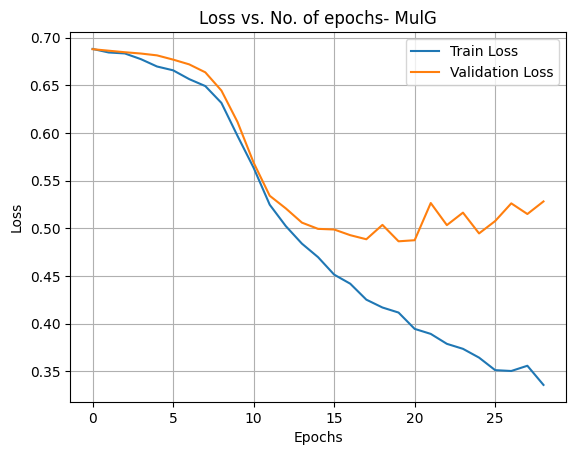

In [34]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs- MulG')
plt.show()

In [20]:
save_results(train_losses, valid_losses, f'/content/{OUTPUT_MODEL_FILE_NAME}.pkl')

In [26]:
import torch
from training.supervised1 import MMDL
from evaluation.performance import accuracy


def test(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    preds = []
    trues = []

    with torch.no_grad():
        for j in test_dataloader:
            # j[0] = [X_v, X_a, X_l]
            modalities = [m.float().to(device) for m in j[0]]

            # labels: (B, 1) -> (B,)
            labels = j[-1].view(-1).long().to(device)

            out = model(modalities)          # (B, 2)
            pred = torch.argmax(out, dim=1) # (B,)

            preds.append(pred)
            trues.append(labels)

    preds = torch.cat(preds, dim=0)
    trues = torch.cat(trues, dim=0)

    acc = accuracy(trues, preds)
    print(f"Test Accuracy (Acc2): {acc * 100:.2f}%")

    return {"Accuracy": acc}


In [66]:
model = torch.load(
    f"/content/{OUTPUT_MODEL_FILE_NAME}.pt",
    weights_only=False
).to(device)

test(
    model,
    test_data,
)

Test Accuracy (Acc2): 78.57%


{'Accuracy': 0.7857142857142857}

## Ablation Studies

### Baseline

In [35]:
import torch
import torch.nn as nn


class CrossModalAttention(nn.Module):
    def __init__(self, d_src, d_tgt):
        super().__init__()
        self.W = nn.Linear(d_tgt, d_src, bias=False)

    def forward(self, X_src, X_tgt):
        X_tgt_proj = self.W(X_tgt)
        scores = torch.bmm(X_src, X_tgt_proj.transpose(1, 2))
        alpha = torch.softmax(scores, dim=-1)
        return torch.bmm(alpha, X_tgt)


class CrossModalGRU(nn.Module):
    def __init__(self, d_src, d_tgt, hidden_dim):
        super().__init__()
        self.attn = CrossModalAttention(d_src, d_tgt)
        self.gru = nn.GRU(d_src + d_tgt, hidden_dim, batch_first=True)

    def forward(self, X_src, X_tgt):
        X_tgt_att = self.attn(X_src, X_tgt)
        X = torch.cat([X_src, X_tgt_att], dim=-1)
        out, _ = self.gru(X)
        return out[:, -1]   # last timestep


In [44]:
class MulGFusionAblation(nn.Module):
    def __init__(
        self,
        d_l, d_a, d_v,
        hidden_dim,
        use_la=True,
        use_lv=True,
        use_al=True,
        use_av=True,
        use_vl=True,
        use_va=True,
    ):
        super().__init__()

        self.use_la = use_la
        self.use_lv = use_lv
        self.use_al = use_al
        self.use_av = use_av
        self.use_vl = use_vl
        self.use_va = use_va

        self.l_a = CrossModalGRU(d_l, d_a, hidden_dim)
        self.l_v = CrossModalGRU(d_l, d_v, hidden_dim)
        self.a_l = CrossModalGRU(d_a, d_l, hidden_dim)
        self.a_v = CrossModalGRU(d_a, d_v, hidden_dim)
        self.v_l = CrossModalGRU(d_v, d_l, hidden_dim)
        self.v_a = CrossModalGRU(d_v, d_a, hidden_dim)

    def forward(self, modalities):
       X_v, X_a, X_l = modalities
       B = X_l.size(0)
       device = X_l.device

    # initialize ZERO TENSORS (not ints!)
       hl = torch.zeros(B, self.l_a.gru.hidden_size, device=device)
       ha = torch.zeros(B, self.a_l.gru.hidden_size, device=device)
       hv = torch.zeros(B, self.v_l.gru.hidden_size, device=device)

       if self.use_la:
        hl = hl + self.l_a(X_l, X_a)
       if self.use_lv:
        hl = hl + self.l_v(X_l, X_v)

       if self.use_al:
        ha = ha + self.a_l(X_a, X_l)
       if self.use_av:
        ha = ha + self.a_v(X_a, X_v)

       if self.use_vl:
        hv = hv + self.v_l(X_v, X_l)
       if self.use_va:
        hv = hv + self.v_a(X_v, X_a)

       return torch.cat([hl, ha, hv], dim=1)



In [45]:
ABLATIONS = {
    "Full MulG": dict(),

    "No Text–Audio": dict(use_la=False, use_al=False),
    "No Text–Vision": dict(use_lv=False, use_vl=False),
    "No Audio–Vision": dict(use_av=False, use_va=False),

    "Unimodal Only": dict(
        use_la=False, use_lv=False,
        use_al=False, use_av=False,
        use_vl=False, use_va=False,
    ),
}


### experiment

In [46]:
HIDDEN_DIM = 64
FUSION_OUT_DIM = 3 * HIDDEN_DIM

results = {}

for name, cfg in ABLATIONS.items():
    print(f"\n===== Running Ablation: {name} =====")

    fusion = MulGFusionAblation(
        d_l=50, d_a=50, d_v=50,
        hidden_dim=HIDDEN_DIM,
        **cfg
    ).to(device)

    head = torch.nn.Linear(FUSION_OUT_DIM, 2).to(device)

    model = MMDL(encoders, fusion, head).to(device)

    train(
        encoders=encoders,
        fusion=fusion,
        head=head,
        train_dataloader=train_data,
        valid_dataloader=valid_data,
        total_epochs=50,
        # task="classification",
        optimtype=torch.optim.AdamW,
        lr=1e-4,
        early_stop=True,
        save=f"/content/{name.replace(' ', '_')}.pt",
    )

    model=(
        torch.load(f"/content/{name.replace(' ', '_')}.pt", map_location=device,weights_only=False)
    )

    res = test(model, test_data)
    results[name] = res["Accuracy"]




===== Running Ablation: Full MulG =====
Epoch [1/50]
Train Loss: 0.3686
Valid Loss: 0.5649 | Accuracy: 75.98%
✔ Saved Best Model

Epoch [2/50]
Train Loss: 0.1828
Valid Loss: 0.7058 | Accuracy: 75.11%

Epoch [3/50]
Train Loss: 0.1555
Valid Loss: 0.7385 | Accuracy: 76.42%
✔ Saved Best Model

Epoch [4/50]
Train Loss: 0.1502
Valid Loss: 0.7796 | Accuracy: 75.11%

Epoch [5/50]
Train Loss: 0.1550
Valid Loss: 0.8003 | Accuracy: 75.55%

Epoch [6/50]
Train Loss: 0.1495
Valid Loss: 0.8193 | Accuracy: 73.80%

Epoch [7/50]
Train Loss: 0.1491
Valid Loss: 0.8139 | Accuracy: 75.11%

Epoch [8/50]
Train Loss: 0.1432
Valid Loss: 0.7768 | Accuracy: 75.98%

Epoch [9/50]
Train Loss: 0.1415
Valid Loss: 0.8363 | Accuracy: 73.80%

Epoch [10/50]
Train Loss: 0.1408
Valid Loss: 0.8092 | Accuracy: 75.11%

Epoch [11/50]
Train Loss: 0.1372
Valid Loss: 0.8372 | Accuracy: 75.11%
Early stopping triggered.
Training Time: 14s961ms
Training Params: 278768
Test Accuracy (Acc2): 76.68%

===== Running Ablation: No Text–Aud

In [47]:
print("\n==== Ablation Results (Acc2) ====")
for k, v in results.items():
    print(f"{k:<20}: {v * 100:.2f}%")



==== Ablation Results (Acc2) ====
Full MulG           : 76.68%
No Text–Audio       : 76.68%
No Text–Vision      : 76.97%
No Audio–Vision     : 76.82%
Unimodal Only       : 59.62%


## Acc7 Evaluation

In [51]:
hidden_dim = 64
fusion_dim = 3 * hidden_dim

head = torch.nn.Linear(fusion_dim, 1).to(device)


In [52]:
def train_regression(
    encoders,
    fusion,
    head,
    train_dataloader,
    valid_dataloader,
    total_epochs=50,
    lr=1e-4,
    weight_decay=1e-2,
    save="best_reg.pt",
    early_stop=True,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MMDL(encoders, fusion, head).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=lr, weight_decay=weight_decay
    )
    criterion = torch.nn.L1Loss()

    best_val = 1e9
    patience = 0

    for epoch in range(total_epochs):
        print(f"Epoch [{epoch+1}/{total_epochs}]")
        model.train()
        train_loss = 0
        n = 0

        for j in train_dataloader:
            optimizer.zero_grad()

            modalities = [m.float().to(device) for m in j[0]]
            labels = j[-1].view(-1).float().to(device)

            out = model(modalities).view(-1)
            loss = criterion(out, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 8)
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            n += labels.size(0)

        train_loss /= n
        print(f"Train MAE: {train_loss:.4f}")

        # ---------- VALIDATION ----------
        model.eval()
        val_loss = 0
        n = 0

        with torch.no_grad():
            for j in valid_dataloader:
                modalities = [m.float().to(device) for m in j[0]]
                labels = j[-1].view(-1).float().to(device)

                out = model(modalities).view(-1)
                loss = criterion(out, labels)

                val_loss += loss.item() * labels.size(0)
                n += labels.size(0)

        val_loss /= n
        print(f"Valid MAE: {val_loss:.4f}")

        if val_loss < best_val:
            best_val = val_loss
            patience = 0
            torch.save(model.state_dict(), save)
            print("✔ Saved Best Model")
        else:
            patience += 1

        if early_stop and patience > 7:
            print("Early stopping triggered.")
            break

        print()

    return model


In [53]:
def to_acc7(y):
    y = torch.clamp(y, -3, 3)
    y = torch.round(y).long()
    return y + 3


In [56]:
def test_regression(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    preds, trues = [], []

    with torch.no_grad():
        for j in test_dataloader:
            modalities = [m.float().to(device) for m in j[0]]
            labels = j[-1].view(-1).float().to(device)

            out = model(modalities).view(-1)

            preds.append(out)
            trues.append(labels)

    preds = torch.cat(preds)
    trues = torch.cat(trues)

    # MAE
    mae = torch.mean(torch.abs(preds - trues)).item()

    # Acc7
    acc7 = (to_acc7(preds) == to_acc7(trues)).float().mean().item()

    print(f"Test MAE  : {mae:.4f}")
    print(f"Test Acc7 : {acc7 * 100:.2f}%")

    return {
        "MAE": mae,
        "Acc7": acc7,
    }


In [64]:
def test_acc2_nonzero(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for j in test_dataloader:
            modalities = [m.float().to(device) for m in j[0]]
            y = j[-1].view(-1).to(device)      # ground truth in [-3,3]

            pred = model(modalities).view(-1) # regression output

            # ❗ EXCLUDE ZERO LABELS (ONLY ground truth)
            mask = y != 0

            if mask.sum() == 0:
                continue

            y_nz = y[mask]
            p_nz = pred[mask]

            # SIGN COMPARISON (NO ROUNDING)
            y_sign = torch.sign(y_nz)
            p_sign = torch.sign(p_nz)

            correct += (y_sign == p_sign).sum().item()
            total += y_sign.numel()

    acc2 = correct / total
    print(f"Test Accuracy (Acc2, non-zero): {acc2 * 100:.2f}%")
    return acc2




In [68]:
# Train
model2 = train_regression(
    encoders=encoders,
    fusion=fusion,
    head=head,
    train_dataloader=train_data,
    valid_dataloader=valid_data,
    total_epochs=50,
    save="/content/MulG_reg.pt"
)



Epoch [1/50]
Train MAE: 0.5242
Valid MAE: 0.5347
✔ Saved Best Model

Epoch [2/50]
Train MAE: 0.5241
Valid MAE: 0.5346
✔ Saved Best Model

Epoch [3/50]
Train MAE: 0.5240
Valid MAE: 0.5345
✔ Saved Best Model

Epoch [4/50]
Train MAE: 0.5239
Valid MAE: 0.5344
✔ Saved Best Model

Epoch [5/50]
Train MAE: 0.5239
Valid MAE: 0.5343
✔ Saved Best Model

Epoch [6/50]
Train MAE: 0.5238
Valid MAE: 0.5341
✔ Saved Best Model

Epoch [7/50]
Train MAE: 0.5237
Valid MAE: 0.5340
✔ Saved Best Model

Epoch [8/50]
Train MAE: 0.5236
Valid MAE: 0.5339
✔ Saved Best Model

Epoch [9/50]
Train MAE: 0.5235
Valid MAE: 0.5339
✔ Saved Best Model

Epoch [10/50]
Train MAE: 0.5235
Valid MAE: 0.5338
✔ Saved Best Model

Epoch [11/50]
Train MAE: 0.5234
Valid MAE: 0.5337
✔ Saved Best Model

Epoch [12/50]
Train MAE: 0.5233
Valid MAE: 0.5335
✔ Saved Best Model

Epoch [13/50]
Train MAE: 0.5233
Valid MAE: 0.5334
✔ Saved Best Model

Epoch [14/50]
Train MAE: 0.5232
Valid MAE: 0.5333
✔ Saved Best Model

Epoch [15/50]
Train MAE: 0.52

In [69]:
# Load best
model2.load_state_dict(
    torch.load("/content/MulG_reg.pt", map_location=device)
)

<All keys matched successfully>

In [70]:
# Test
results = [test_regression(model2, test_data), test(
    model,
    test_data,
)]


Test MAE  : 0.4307
Test Acc7 : 59.62%
Test Accuracy (Acc2): 78.57%
